In [1]:
import pandas as pd
import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=100, random_state=1)

In [3]:
bvsp = yf.Ticker("^BVSP")

In [4]:
bvsp = bvsp.history(period="max")

In [5]:
bvsp

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-04-27,24.799999,25.400000,24.500000,24.500000,0,0,0
1993-04-28,24.500000,24.600000,23.700001,24.299999,0,0,0
1993-04-29,24.299999,24.799999,23.700001,23.700001,0,0,0
1993-04-30,23.700001,24.200001,23.700001,24.100000,0,0,0
1993-05-03,24.100000,24.400000,23.799999,24.100000,0,0,0
...,...,...,...,...,...,...,...
2022-08-17,113508.000000,114146.000000,112483.000000,113708.000000,14652800,0,0
2022-08-18,113708.000000,114375.000000,113304.000000,113813.000000,10644200,0,0
2022-08-19,113807.000000,113807.000000,111146.000000,111496.000000,12678600,0,0


<AxesSubplot:xlabel='Date'>

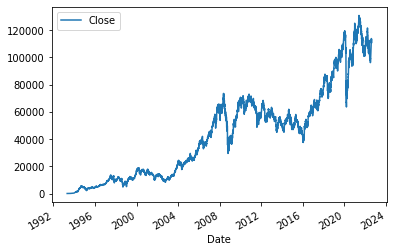

In [6]:
bvsp.plot.line(y="Close", use_index=True)

In [7]:
del bvsp["Dividends"]
del bvsp["Stock Splits"]

In [8]:
bvsp["Next Price"] = bvsp["Close"].shift(-1)

In [9]:
bvsp["Target"] = (bvsp["Next Price"] > bvsp["Close"]).astype(int)

In [10]:
train = bvsp.iloc[:-100]
test = bvsp.iloc[-100:]

predictors = ["Open", "High", "Low", "Close", "Volume"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=300, random_state=1)

In [11]:
preds = model.predict(test[predictors])

In [12]:
preds = pd.Series(preds, index=test.index)

In [13]:
precision_score(test["Target"], preds)

0.4819277108433735

In [14]:
combined = pd.concat([test["Target"], preds], axis=1)

<AxesSubplot:xlabel='Date'>

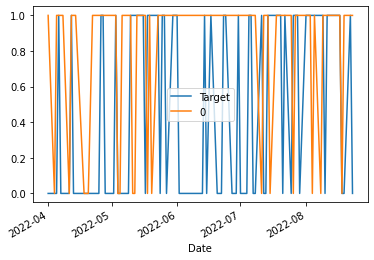

In [15]:
combined.plot()

In [16]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [18]:
predictions = backtest(bvsp, model, predictors)

In [19]:
predictions["Predictions"].value_counts()

0    2558
1    2199
Name: Predictions, dtype: int64

In [20]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5188722146430196

In [21]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.52386
0    0.47614
Name: Target, dtype: float64

In [22]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = bvsp.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    bvsp[ratio_column] = bvsp["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    bvsp[trend_column] = bvsp.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors += [ratio_column, trend_column]

In [23]:
bvsp = bvsp.dropna()

In [24]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [25]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [26]:
predictions = backtest(bvsp, model, new_predictors)

In [27]:
predictions["Predictions"].value_counts()

0.0    3468
1.0     288
Name: Predictions, dtype: int64

In [28]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5104166666666666

In [29]:
bvsp

,Open,High,Low,Close,Volume,Next Price,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1997-05-14,10650.0,10650.0,10188.0,10283.0,0,10354.0,1,0.982562,0.0,0.978569,3.0,1.086880,37.0,1.416977,141.0,2.561637,583.0
1997-05-15,10560.0,10560.0,10256.0,10354.0,0,10499.0,1,1.003440,1.0,0.986885,3.0,1.091205,38.0,1.422897,142.0,2.572704,584.0
1997-05-16,10354.0,10511.0,10354.0,10499.0,0,10506.0,1,1.006953,2.0,1.000572,3.0,1.103225,38.0,1.438825,142.0,2.601960,585.0
1997-05-19,10556.0,10556.0,10471.0,10506.0,0,10641.0,1,1.000333,2.0,1.004590,3.0,1.100961,38.0,1.435825,142.0,2.596949,585.0
1997-05-20,10641.0,10641.0,10374.0,10641.0,0,10715.0,1,1.006384,2.0,1.017635,4.0,1.111478,39.0,1.450247,142.0,2.623434,586.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-16,113034.0,113626.0,112690.0,113512.0,12986400,113708.0,1,1.002119,2.0,1.014837,4.0,1.094026,33.0,1.041669,127.0,1.095717,526.0
2022-08-17,113508.0,114146.0,112483.0,113708.0,14652800,113813.0,1,1.000863,2.0,1.010317,4.0,1.095365,33.0,1.043628,128.0,1.097248,526.0
2022-08-18,113708.0,114375.0,113304.0,113813.0,10644200,111496.0,0,1.000461,2.0,1.003945,5.0,1.095807,34.0,1.044700,129.0,1.097918,526.0
